In [1]:
#Import libraries
import numpy as np
import keras
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
from datetime import datetime, timedelta
from tensorflow.keras.models import save_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error


In [ ]:
""" 
Read the DataFrame
Metioned in the README.txt file
"""

df = pd.read_csv('ETH-USD.csv')
df=df.rename(columns = {'Unnamed: 0':'timestap'})
df.head()

,timestap,open,high,low,close,rsi,ema
0,0,1889.47,1890.06,1889.30,1889.81,50.262001,2517.787061
1,1,1889.86,1890.21,1889.80,1890.12,50.262001,2517.787061
2,2,1890.11,1890.19,1889.90,1889.96,50.262001,2517.787061
3,3,1889.95,1890.17,1889.84,1889.87,50.262001,2517.787061
4,4,1889.87,1890.24,1889.69,1890.16,50.262001,2517.787061


In [ ]:
""" 
Use the best Technical Indicators depending ont the training DataFrames
Forex / Commodities: open high low close ema obv
Crypto: open high low close ema obv

open     0.999995
high     0.999997
low      0.999997
close    1.000000
ema      0.999964
"""

#Check Correlation
df = df.drop(['timestap', 'rsi'], axis=1)
df.corrwith(df["close"])

open     0.999995
high     0.999997
low      0.999997
close    1.000000
ema      0.999964
dtype: float64

In [ ]:
"""   
Data Preprocessing
"""
import warnings
warnings.filterwarnings('ignore')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(df.values.reshape((-1, 1)))

# Function to create the dataset [WINDOWED APPROACH]
def create_dataset(dataset, N=60):
    X, Y = [], []
    for i in range(len(dataset) - N):
        X.append(dataset[i:i + N])
        Y.append(dataset[i + N, -1])
    return np.array(X), np.array(Y)

# Apply the new function
N = 60
X_train, y_train = create_dataset(train_scaled, N)



X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1).astype('float32')
y_train = y_train.reshape(y_train.shape[0], 1).astype('float32')

#Test With Different sizes (If you can't handle all data points)
# X_train = X_train[-100000:] #Get the latest data points
# y_train = y_train[-100000:] #Get the latest data points

print("Train shapes for X and y respectivelly", X_train.shape, y_train.shape)
print("Train sizes for X and y respectivelly", X_train.size, y_train.size)
print('Full train Lenght', len(train_scaled))

Train shapes for X and y respectivelly (3436665, 60, 1) (3436665, 1)
Train sizes for X and y respectivelly 206199900 3436665
Full train Lenght 3436725


In [ ]:
""" 
AchillesV1 Architecture
"""
from keras.utils import plot_model
#Create the model (Optimized)
model = Sequential()
model.add(LSTM(256, return_sequences=True, recurrent_activation='sigmoid', activation='tanh', recurrent_dropout=0, unroll=False, use_bias=True, input_shape=(N, 1))) #(X_train.shape[1], 1) also works fine
model.add(Dropout(0.4))
model.add(LSTM(128, return_sequences=True, recurrent_activation='sigmoid', activation='tanh', recurrent_dropout=0, unroll=False, use_bias=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True, recurrent_activation='sigmoid', activation='tanh', recurrent_dropout=0, unroll=False, use_bias=True))
model.add(Dropout(0.3))
model.add(LSTM(32, return_sequences=True, recurrent_activation='sigmoid', activation='tanh', recurrent_dropout=0, unroll=False, use_bias=True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()
#Compile the model 
model.compile(
loss='mean_squared_error',
optimizer=Adam(learning_rate=0.00013,  beta_1=0.9, beta_2=0.999), 
metrics=['mae', keras.metrics.RootMeanSquaredError()],
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 256)           264192    
                                                                 
 dropout_16 (Dropout)        (None, 60, 256)           0         
                                                                 
 lstm_13 (LSTM)              (None, 60, 128)           197120    
                                                                 
 dropout_17 (Dropout)        (None, 60, 128)           0         
                                                                 
 lstm_14 (LSTM)              (None, 60, 64)            49408     
                                                                 
 dropout_18 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_15 (LSTM)              (None, 60, 32)           

In [35]:
""" 
Usually you need a Powerful GPU to run
If that is not the case try reducing the data points
and the size of the DataFrame
"""

warnings.filterwarnings('ignore')
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3, min_lr=0.00013)
]      
                           
history = model.fit(X_train, y_train, epochs=20, batch_size=360, validation_split=0.2, verbose=1, callbacks=callbacks)
val_loss = min(history.history['val_loss'])
print(val_loss)

Epoch 1/20
7638/7638 [==============================] - 306s 40ms/step - loss: 0.0031 - mae: 0.0287 - root_mean_squared_error: 0.0561 - val_loss: 1.8621e-05 - val_mae: 0.0036 - val_root_mean_squared_error: 0.0043 - lr: 1.3000e-04
Epoch 2/20
7638/7638 [==============================] - 298s 39ms/step - loss: 7.9094e-04 - mae: 0.0194 - root_mean_squared_error: 0.0281 - val_loss: 2.2033e-05 - val_mae: 0.0040 - val_root_mean_squared_error: 0.0047 - lr: 1.3000e-04
Epoch 3/20
7638/7638 [==============================] - 297s 39ms/step - loss: 7.4962e-04 - mae: 0.0192 - root_mean_squared_error: 0.0274 - val_loss: 6.0920e-05 - val_mae: 0.0065 - val_root_mean_squared_error: 0.0078 - lr: 1.3000e-04
Epoch 4/20
7638/7638 [==============================] - 298s 39ms/step - loss: 7.3311e-04 - mae: 0.0190 - root_mean_squared_error: 0.0271 - val_loss: 1.8551e-05 - val_mae: 0.0034 - val_root_mean_squared_error: 0.0043 - lr: 1.3000e-04
Epoch 5/20
7638/7638 [==============================] - 299s 39ms/st

In [ ]:
"""
Save the model
"""
save_model(model, 'ACHILLES V1.keras', overwrite=True)

In [ ]:
"""  
You may need an active MetaTrader 5
Account for testing. You can open one in:
https://www.metatrader5.com/en
"""

if mt5.initialize():
    # Replace with your login credentials
    mt5.login(login="Login", server="Server", password="Your Password")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 256)           264192    
                                                                 
 dropout_16 (Dropout)        (None, 60, 256)           0         
                                                                 
 lstm_13 (LSTM)              (None, 60, 128)           197120    
                                                                 
 dropout_17 (Dropout)        (None, 60, 128)           0         
                                                                 
 lstm_14 (LSTM)              (None, 60, 64)            49408     
                                                                 
 dropout_18 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_15 (LSTM)              (None, 60, 32)           

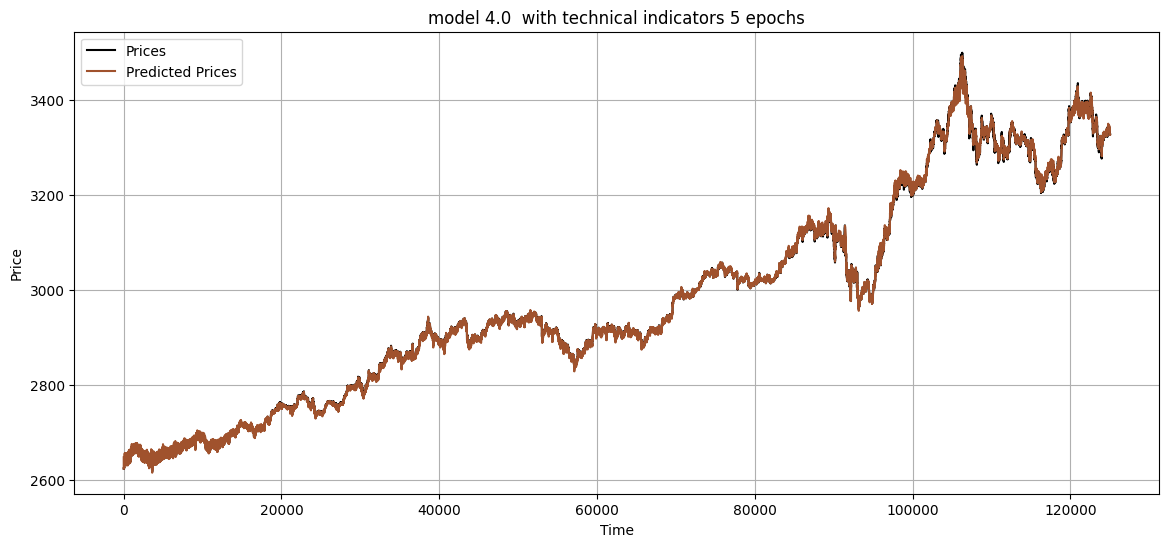

1.3438481007952456
1.1592446250879258
0.0004474505670063913
0.999907336567824


In [ ]:
""" 
>Login to any MT5 Account
>Load the Model
>Create a Test DataFrame
>Reshape the Predictions (Keeping in mind the Windowed approach)
>Predict and Plot the Predictions
"""
#Bring the Model into account
model_1 = keras.models.load_model("ACHILLES V1.keras")
model_1.summary()

now = datetime.now()

#CREATE A THE TEST DF
test = mt5.copy_rates_range('XAUUSD', mt5.TIMEFRAME_M1, datetime(2025, 1, 1), now)
test = pd.DataFrame(test)
test_1 = test['close'].tail(137613) #87600 Minures (One Month)


# Moving average with a window size of 3
test_scaled = scaler.fit_transform(np.array(test_1).reshape(-1, 1))

N = 60
_, X_test = create_dataset(test_scaled, N=N)
_, y_test = create_dataset(test_scaled, N=N)

#RESHAPE FOR PREDICTIONS
elements_two = X_test.size
divisible_two = (elements_two // 120) * 120
X_predict_shape = X_test[:divisible_two]
X_test = X_predict_shape.reshape(-1, 60, 1)

elements_one = y_test.size
divisible_one = (elements_one // 120) *120
y_predict_shape = y_test[:divisible_one]
y_test = y_predict_shape.reshape(-1, 60, 1)

#Make Predictions
y_pred = model_1.predict(X_test)

#Inverse scaling
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_real = scaler.inverse_transform(y_test.reshape(-1, 1))

#You can smooth the results if desired
window_size = 1  # Adjust the window size as needed
y_pred_smooth = np.convolve(y_pred.flatten(), np.ones(window_size)/window_size, mode='valid')

# Plot the results
now = datetime.now()
sixty_days = now + timedelta(days=60)
sixty_days = sixty_days.replace(microsecond=0)
date_range = pd.date_range(start=now.replace(microsecond=0), end=sixty_days, freq='1min')
date_range = date_range[date_range.dayofweek < 5]
time_df = pd.DataFrame(date_range)
rows = len(time_df)
print(f"Number of rows: {(rows)}")
plt.figure(figsize=(14, 6))
plt.plot(y_real, label='Prices', color='black')
plt.plot(y_pred_smooth, label='Predicted Prices', color='sienna')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('model 4.0  with technical indicators 5 epochs')
plt.grid(True)
plt.legend()
plt.show()

print(mean_absolute_error(y_true=y_real, y_pred=y_pred_smooth))
print(np.sqrt(mean_absolute_error(y_true=y_real, y_pred=y_pred_smooth)))
print(mean_absolute_percentage_error(y_true=y_real, y_pred=y_pred_smooth))
print(r2_score(y_true=y_real, y_pred=y_pred_smooth))

In [ ]:
#You may save teh predictions if you wish
predicted_df = pd.DataFrame(y_pred)
predicted_df.to_csv("predictions_past.csv")

NOW; With this done is important to note this is just the start ヾ(⌐■_■)ノ♪

We may predict the past with 0.9999% accuracy. But this does not mean we're done. Remember, we want to predict the future, the past is already gone, anyone can predict what already happenned. To predict the future we need to take a clever approach. As you migh have noticed. We added True in return_sequences of our AchillesV1. This is because we will need to return the whole sequence and not only the predictions for predicting into the future. This will be really helpful for foward predictions.

1. ----> We will use this model to predict into the future in the Predictions File
2. ----> We will save the Predictions made by our model
3. ----> We will use them in our Trading Bot for Autmatic Trading
4. ----> Take a nap for your mental health
5. ----> Hit your head to the keyboard because of debugging
6. ----> Then, rest when the trading bot is active in your preffered MT5 Trading account